# House prices

Kairos (April 2018)


## Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

## Data
79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

## Challenge
Predicting the final price of each home.

## Method
We'll use Tensorflow as out method to develop the project.

## Notice
Run at least once '0.House_prices_preparing_dataset' before run this snippet.

## Synthetic Features and Outliers
This notebook continues the linear regression model started in the previous exercise. In this exercise, we'll try new features and study the effect of outliers in the input data.

  * Create a synthetic feature that is the ratio of two other features
  * Use this new feature as an input to a linear regression model
  * Improve the effectiveness of the model by identifying and clipping (removing) outliers out of the input data

## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2. Load our data set
Next, we'll load our data set and show information about it.

In [2]:
housing_dataframe = pd.read_csv("input/cleaned_houses_prices_train.csv", sep=",")
housing_dataframe.shape
housing_dataframe.describe()
housing_dataframe.info()
housing_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 65 columns):
Id               1451 non-null int64
MSSubClass       1451 non-null int64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
OverallCond      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
Gar

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,0,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,1,0,0,0,0,1,0,0,0,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,0,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,2,0,1,0,0,0,0,0,0,1
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1447,1457,20,13175,6,6,1978,1988,119.0,790,163,...,1,0,2,0,0,1,1,0,0,0
1448,1458,70,9042,7,9,1941,2006,0.0,275,0,...,5,0,0,0,0,0,0,0,0,0
1449,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,1,0,1,0,2,0,0,0,0,0


## 3. Random the data
We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we scale "SalePrice" to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [3]:
housing_dataframe = housing_dataframe.reindex(
    np.random.permutation(housing_dataframe.index))
housing_dataframe["SalePrice"] /= 1000.0
housing_dataframe

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
536,539,20,11553,5,5,1968,1968,188.0,673,0,...,1,0,2,0,0,1,0,0,0,0
987,994,60,8846,6,5,2005,2006,0.0,0,0,...,0,0,0,0,0,0,0,0,1,2
1106,1113,20,7100,5,7,1957,1957,0.0,708,0,...,1,0,2,0,2,1,0,0,0,0
1438,1448,60,10000,8,5,1995,1996,438.0,1079,0,...,0,0,0,0,0,0,0,0,0,0
891,895,90,7018,5,5,1979,1979,0.0,0,0,...,4,0,2,0,0,1,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,154,20,13500,6,7,1960,1975,0.0,429,1080,...,1,0,1,0,0,1,0,0,0,0
716,720,20,9920,5,6,1969,1969,0.0,523,0,...,1,0,2,0,0,1,0,0,0,0
143,144,20,10335,7,5,1999,1999,183.0,679,0,...,0,0,0,0,0,0,0,0,0,0
980,987,50,5310,6,8,1910,2003,0.0,0,0,...,1,0,1,0,0,0,0,0,0,0


## 4. Examine the data
It's a good idea to get to know your data a little bit before you work with it.
We'll print out a quick summary of a few useful statistics on each column.
This will include things like mean, standard deviation, max, min, and various quantiles.

In [4]:
housing_dataframe.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
count,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,...,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0
mean,729.4,56.9,10507.8,6.1,5.6,1971.1,1984.8,103.8,442.3,46.8,...,0.7,0.0,0.9,0.1,0.2,0.7,0.2,0.1,0.2,0.3
std,421.7,42.4,9993.0,1.4,1.1,30.2,20.7,181.1,455.4,161.8,...,0.8,0.3,1.0,0.2,0.5,0.7,0.7,0.4,0.8,0.9
min,1.0,20.0,1300.0,1.0,1.0,1872.0,1950.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,364.5,20.0,7537.5,5.0,5.0,1954.0,1966.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,729.0,50.0,9477.0,6.0,5.0,1972.0,1993.0,0.0,381.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75%,1094.5,70.0,11600.0,7.0,6.0,2000.0,2004.0,166.0,707.0,0.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
max,1460.0,190.0,215245.0,10.0,9.0,2010.0,2010.0,1600.0,5644.0,1474.0,...,5.0,5.0,4.0,1.0,4.0,3.0,6.0,2.0,8.0,5.0


*Next*, we'll set up our input function, and define the function for model training:

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [6]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = housing_dataframe[[my_feature]].astype('float32')
  my_label = "SalePrice"
  targets = housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print "Final RMSE (on training data): %0.2f" % root_mean_squared_error
  
  return calibration_data

## 5. Try a synthetic feature.
The "1stFlrSF", "2ndFlrSF", "GrLivArea" and "TotalBsmtSF" features count total area for a given house.

We can create a synthetic feature that's a ratio of our two source features.

Create a feature called "SQMeter_price", and use that as an input in the model code cell below.

What is the best performance you can get with this single feature? (The better the performance, the better your regression line should fit the data and the lower the final RMSE should be.)

In [7]:
# Create a new category for total habitable surface
housing_dataframe["habitableSF"] = housing_dataframe["1stFlrSF"] + housing_dataframe["2ndFlrSF"] + housing_dataframe["GrLivArea"]

# Create a new synthetic feature
housing_dataframe['SQMeter_price'] = housing_dataframe.apply(lambda row: row['SalePrice'] * 1000 / row['habitableSF'], axis=1)


Training model...
RMSE (on training data):
  period 00 : 156.74
  period 01 : 118.43
  period 02 : 85.38
  period 03 : 68.51
  period 04 : 66.80
  period 05 : 65.61
  period 06 : 65.00
  period 07 : 65.49
  period 08 : 65.00
  period 09 : 64.97
Model training finished.


,predictions,targets
count,1451.0,1451.0
mean,181.2,180.6
std,46.8,79.3
min,42.6,34.9
25%,150.4,129.9
50%,180.4,162.5
75%,208.3,214.0
max,414.8,755.0


Final RMSE (on training data): 64.97


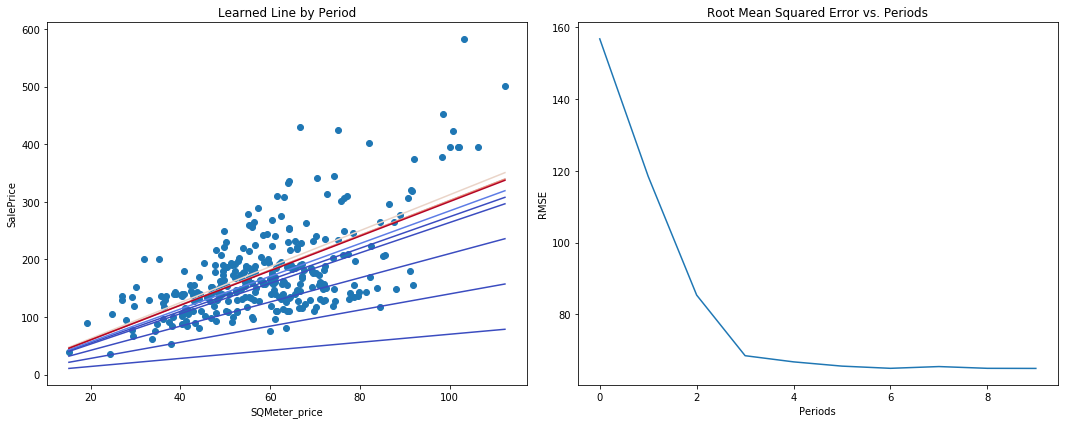

In [8]:
calibration_data = train_model(
    learning_rate=0.004,
    steps=350,
    batch_size=5,
    input_feature="SQMeter_price")

## 9. Identify outliers
The calibration data shows most scatter points aligned to a line. The line is almost vertical, but we'll come back to that later. Right now let's focus on the ones that deviate from the line. We notice that they are relatively few in number.

Plotting a histogram of "totalFlrsSF" reveals that we have a few outliers in our input data.

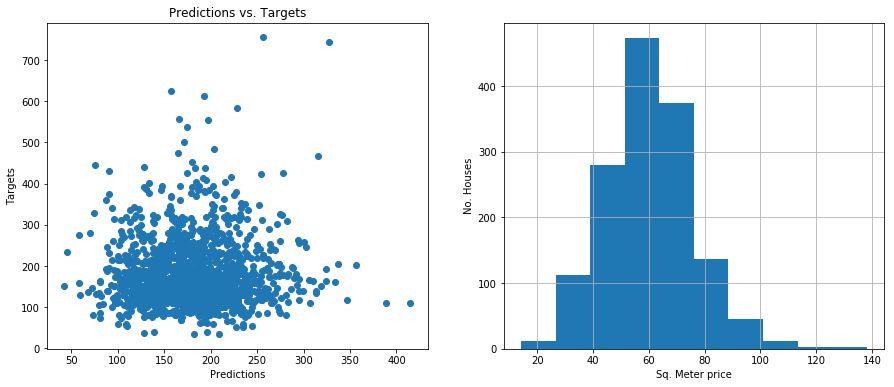

In [11]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Predictions vs. Targets")
plt.ylabel('Targets')
plt.xlabel('Predictions')
plt.scatter(calibration_data["predictions"], calibration_data["targets"])
plt.subplot(1, 2, 2)

plt.ylabel('No. Houses')
plt.xlabel('Sq. Meter price')
_ = housing_dataframe["SQMeter_price"].hist()

## 10. Clip outliers
See if you can improve model fit further by setting outlier values of SQMeter_price to some sane minimum or maximum.

For reference, here's a quick example of how to apply a function to a Pandas Series:

clipped_feature = my_feature_column["my_feature_name"].apply(lambda x: max(x, 0))
The above clipped_feature will have no values less than 0.

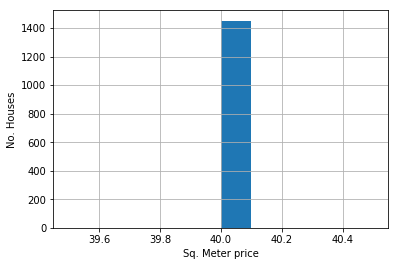

In [19]:
housing_dataframe["SQMeter_price"] = (
    housing_dataframe["SQMeter_price"]).apply(lambda x: min(x, 80))
plt.ylabel('No. Houses')
plt.xlabel('Sq. Meter price')
_ = housing_dataframe["SQMeter_price"].hist()

To verify that clipping worked, let's train again and print the calibration data once more.

Training model...
RMSE (on training data):
  period 00 : 159.45
  period 01 : 123.86
  period 02 : 93.07
  period 03 : 78.27
  period 04 : 72.09
  period 05 : 71.04
  period 06 : 70.97
  period 07 : 71.52
  period 08 : 70.89
  period 09 : 70.87
Model training finished.


,predictions,targets
count,1451.0,1451.0
mean,180.1,180.6
std,36.3,79.3
min,44.3,34.9
25%,156.2,129.9
50%,187.3,162.5
75%,216.3,214.0
max,218.3,755.0


Final RMSE (on training data): 70.87


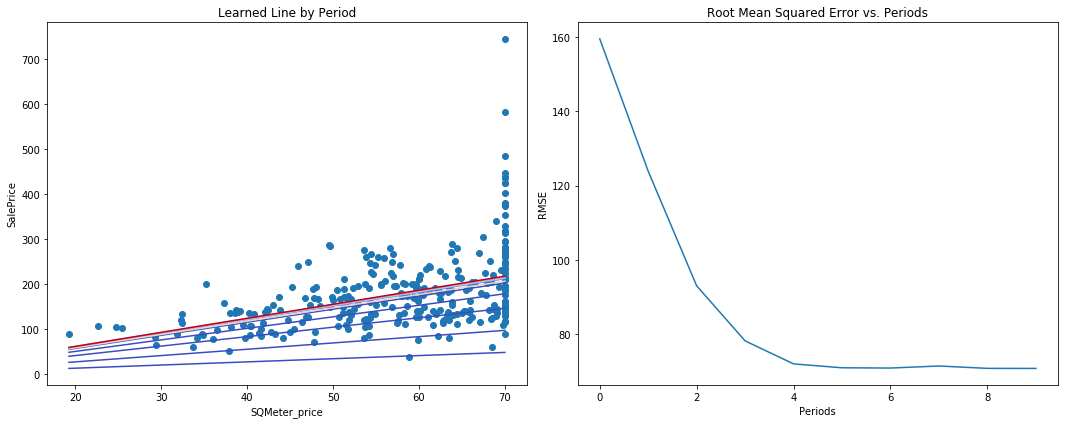

In [17]:
calibration_data = train_model(
    learning_rate=0.004,
    steps=350,
    batch_size=5,
    input_feature="SQMeter_price")

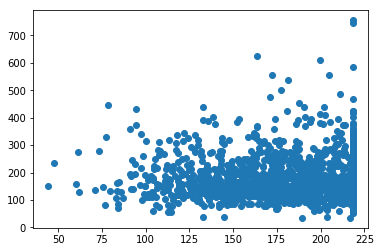

In [20]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])